### Plots for logit based

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np
from sklearn.metrics import roc_auc_score
import seaborn as sns

import numpy as np

df_results = pd.read_csv("./processed_csvs/classification.csv")


def convert_to_float_list(string_list):
    return [float(x) for x in string_list.strip("[]").split(", ")]


# Apply the function to the 'probabilities' column
df_results["probabilities"] = df_results["probabilities"].apply(convert_to_float_list)
df_results["positive_probabilities"] = [p[1] for p in df_results["probabilities"]]
all_datasets = df_results["dataset"].unique()
all_models = df_results["model"].unique()
all_annotators = df_results["annotator"].unique()
df_results = df_results.sort_values(by=["dataset", "model", "annotator"])
all_auroc = []

df_list = []

for dataset in all_datasets:
    for model in all_models:
        for annotator in all_annotators:
            df = df_results[
                (df_results["dataset"] == dataset)
                & (df_results["model"] == model)
                & (df_results["annotator"] == annotator)
            ].copy()
            labels = df["gold_class"].unique()
            auroc = roc_auc_score(df["gold_class"], df["positive_probabilities"])
            df["auroc"] = auroc
            df_list.append(df)

df_results = pd.concat(df_list)
df_results = df_results.drop(["instance", "probabilities"], axis=1)

df_results_grouped = (
    df_results.groupby(["task_type", "dataset", "model", "annotator"])
    .mean()
    .reset_index()
)

df_results_grouped = df_results_grouped_og[["dataset", "model", "annotator", "auroc"]]
# create a new column called annot_ranking that ranks the annotators based on their auroc within a subgroup
# defined by dataset and model.

df_results_grouped["annot_ranking"] = (
    df_results_grouped.groupby(["dataset", "model"])["auroc"]
    .rank(ascending=False)
    .astype(int)
)

df_results_grouped_og = df_results_grouped.copy()

/tmp/ipykernel_84863/1305841401.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results_grouped["annot_ranking"] = (


Text(0.5, 1.0, 'Asthma Classification')

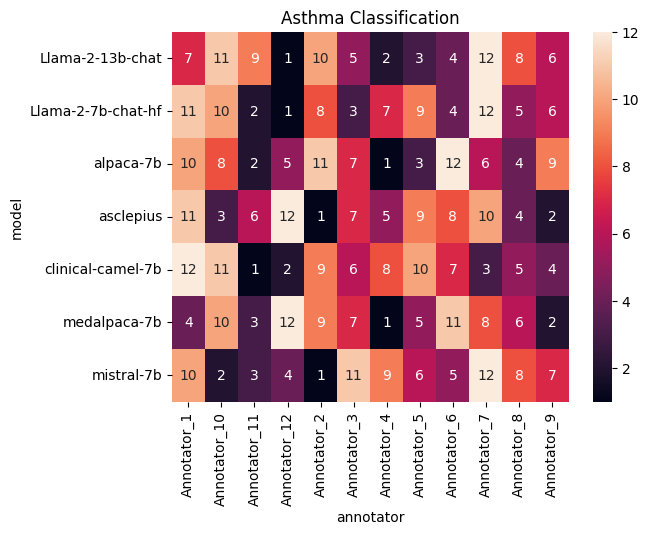

In [28]:
df = df_results_grouped_og.copy()
df = df[df["dataset"] == "asthma_classification"]

# plot a heatmap where each row is a model and each column is an annotator, the values should be defined by auroc

df = df.pivot(index="model", columns="annotator", values="annot_ranking")
sns.heatmap(df, annot=True)
plt.title("Asthma Classification")

In [32]:
# average df on  the model axis
print(df.median(axis=0))

annotator
Annotator_1     10.0
Annotator_10    10.0
Annotator_11     3.0
Annotator_12     4.0
Annotator_2      9.0
Annotator_3      7.0
Annotator_4      5.0
Annotator_5      6.0
Annotator_6      7.0
Annotator_7     10.0
Annotator_8      5.0
Annotator_9      6.0
dtype: float64


- model (7)
- expert (12)
- task  (1)
- performance  





In [ ]:
# 

/tmp/ipykernel_84863/2859125049.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results_grouped["annot_ranking"] = (


Annotator_1 1
Annotator_2 3
Annotator_3 3
Annotator_4 1
Annotator_5 2
Annotator_6 1
Annotator_7 2
Annotator_8 1
Annotator_9 5
Annotator_10 3
Annotator_11 7
Annotator_12 2


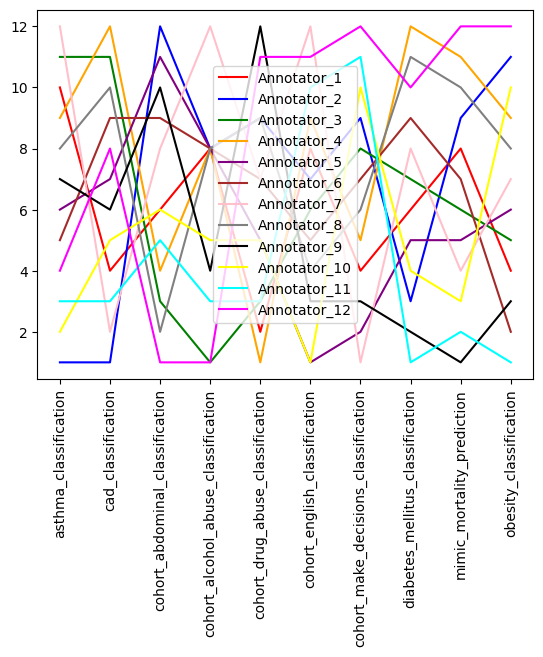

In [13]:


# now, let's choose "mistral-7b" as the model. Let the Y axis be the rankings, and the X axis be the datasets, draw
# a line for each annotator showing their ranking across datasets.

df_results_grouped = df_results_grouped[df_results_grouped["model"] == "mistral-7b"]
df_results_grouped = df_results_grouped.sort_values(by=["dataset", "annot_ranking"])

# create a dictionary that maps annotators to colors

COLORS = {
    "Annotator_1": "red",
    "Annotator_2": "blue",
    "Annotator_3": "green",
    "Annotator_4": "orange",
    "Annotator_5": "purple",
    "Annotator_6": "brown",
    "Annotator_7": "pink",
    "Annotator_8": "gray",
    "Annotator_9": "black",
    "Annotator_10": "yellow",
    "Annotator_11": "cyan",
    "Annotator_12": "magenta",
}

fig, ax = plt.subplots()
for annotator, color in COLORS.items():
    df = df_results_grouped[df_results_grouped["annotator"] == annotator]
    ax.plot(df["dataset"], df["annot_ranking"], label=annotator, color=color)
ax.legend()
plt.xticks(rotation=90)

# now, for each annotator print the count of how many times they were in the first three positions

for annotator in COLORS.keys():
    df = df_results_grouped[df_results_grouped["annotator"] == annotator]
    print(annotator, (df["annot_ranking"] <= 3).sum())

In [23]:
for model in df_results_grouped_og["model"].unique():
    print("\n------------")
    print(model)

    for annotator in COLORS.keys():
        df = df_results_grouped_og[df_results_grouped_og["annotator"] == annotator]
        df = df[df["model"] == model]

        print(annotator, (df["annot_ranking"] <= 3).sum())


------------
Llama-2-13b-chat
Annotator_1 2
Annotator_2 1
Annotator_3 1
Annotator_4 4
Annotator_5 1
Annotator_6 3
Annotator_7 4
Annotator_8 2
Annotator_9 4
Annotator_10 3
Annotator_11 4
Annotator_12 2

------------
Llama-2-7b-chat-hf
Annotator_1 2
Annotator_2 0
Annotator_3 3
Annotator_4 3
Annotator_5 1
Annotator_6 3
Annotator_7 2
Annotator_8 4
Annotator_9 2
Annotator_10 3
Annotator_11 3
Annotator_12 5

------------
alpaca-7b
Annotator_1 5
Annotator_2 2
Annotator_3 2
Annotator_4 1
Annotator_5 4
Annotator_6 1
Annotator_7 3
Annotator_8 0
Annotator_9 3
Annotator_10 2
Annotator_11 5
Annotator_12 2

------------
asclepius
Annotator_1 2
Annotator_2 4
Annotator_3 2
Annotator_4 0
Annotator_5 3
Annotator_6 4
Annotator_7 2
Annotator_8 2
Annotator_9 6
Annotator_10 4
Annotator_11 0
Annotator_12 2

------------
clinical-camel-7b
Annotator_1 5
Annotator_2 0
Annotator_3 3
Annotator_4 4
Annotator_5 3
Annotator_6 0
Annotator_7 5
Annotator_8 2
Annotator_9 2
Annotator_10 1
Annotator_11 2
Annotator_12 3



In [2]:
def get_results_stacked(df_results_grouped, how="max"):
    datasets = df_results_grouped["dataset"].unique()
    models = df_results_grouped["model"].unique()
    if how == "max":
        df_results_grouped_max = (
            df_results_grouped[["dataset", "model", "auroc"]]
            .groupby(["dataset", "model"])
            .max()
            .reset_index()
        )
    elif how == "min":
        df_results_grouped_max = (
            df_results_grouped[["dataset", "model", "auroc"]]
            .groupby(["dataset", "model"])
            .min()
            .reset_index()
        )
    else:
        df_results_grouped_max = (
            df_results_grouped[["dataset", "model", "auroc"]]
            .groupby(["dataset", "model"])
            .mean()
            .reset_index()
        )

    df_results_grouped_max = (
        df_results_grouped_max[["model", "auroc"]].groupby("model").mean()
    )

    return df_results_grouped_max

In [3]:
df_results_grouped = df_results_grouped[["dataset", "model", "annotator", "auroc"]]

annotators = df_results_grouped["annotator"].unique()
datasets = df_results_grouped["dataset"].unique()
models = df_results_grouped["model"].unique()

# for each model,dataset pair, get the annotator with the highest f1

In [4]:
df_results_grouped_max_cnt = get_results_stacked(df_results_grouped, "max")
df_results_grouped_min_cnt = get_results_stacked(df_results_grouped, "min")
df_results_grouped_mean_cnt = get_results_stacked(df_results_grouped, "mean")
df_results_grouped_max_cnt["type"] = "Best"
df_results_grouped_min_cnt["type"] = "Worst"
df_results_grouped_mean_cnt["type"] = "Median"

# stack

results = pd.concat(
    [
        df_results_grouped_max_cnt,
        df_results_grouped_mean_cnt,
        df_results_grouped_min_cnt,
    ]
)


ORDER_MAP = {
    "Llama-2-7b-chat-hf": 2,
    "Llama-2-13b-chat": 1,
    "alpaca-7b": 3,
    "mistral-7b": 0,
    "asclepius": 6,
    "clinical-camel-7b": 5,
    "medalpaca-7b": 7,
}

results["order"] = results.index.map(ORDER_MAP)
results = results.sort_values(by=["order", "type"])

In [8]:
colors

[(0.33725490196078434, 0.45647058823529396, 0.6509803921568628),
 (0.8121568627450981, 0.5329411764705883, 0.3760784313725489),
 (0.36588235294117644, 0.6262745098039216, 0.4254901960784314),
 (0.7223529411764706, 0.35215686274509816, 0.36470588235294116),
 (0.519607843137255, 0.47254901960784323, 0.6764705882352939),
 (0.556470588235294, 0.4717647058823529, 0.39647058823529413),
 (0.823921568627451, 0.5760784313725489, 0.7517647058823529),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.7654901960784315, 0.7058823529411765, 0.4894117647058822),
 (0.43333333333333335, 0.6874509803921568, 0.7627450980392156)]

In [5]:
MODEL_MAP = {
    "mistral-7b": "Mistral (7b)",
    "Llama-2-7b-chat-hf": "Llama-2 (7b)",
    "asclepius": "Asclepius (7b)",
    "Llama-2-13b-chat": "Llama-2 (13b)",
    "clinical-camel-7b": "Clin-Camel (13b)",
    "alpaca-7b": "Alpaca (7b)",
    "medalpaca-7b": "MedAlpaca (7b)",
}
models_a = ["Mistral (7b)", "Llama-2 (7b)", "Llama-2 (13b)", "Alpaca (7b)"]
models_b = ["Asclepius (7b)", "Clin-Camel (13b)", "MedAlpaca (7b)"]
results = results.reset_index()

results["model"] = results.model.map(MODEL_MAP)
results.columns = ["Model", "AUROC", "Prompt", "order"]

/tmp/ipykernel_37407/2888371410.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15)


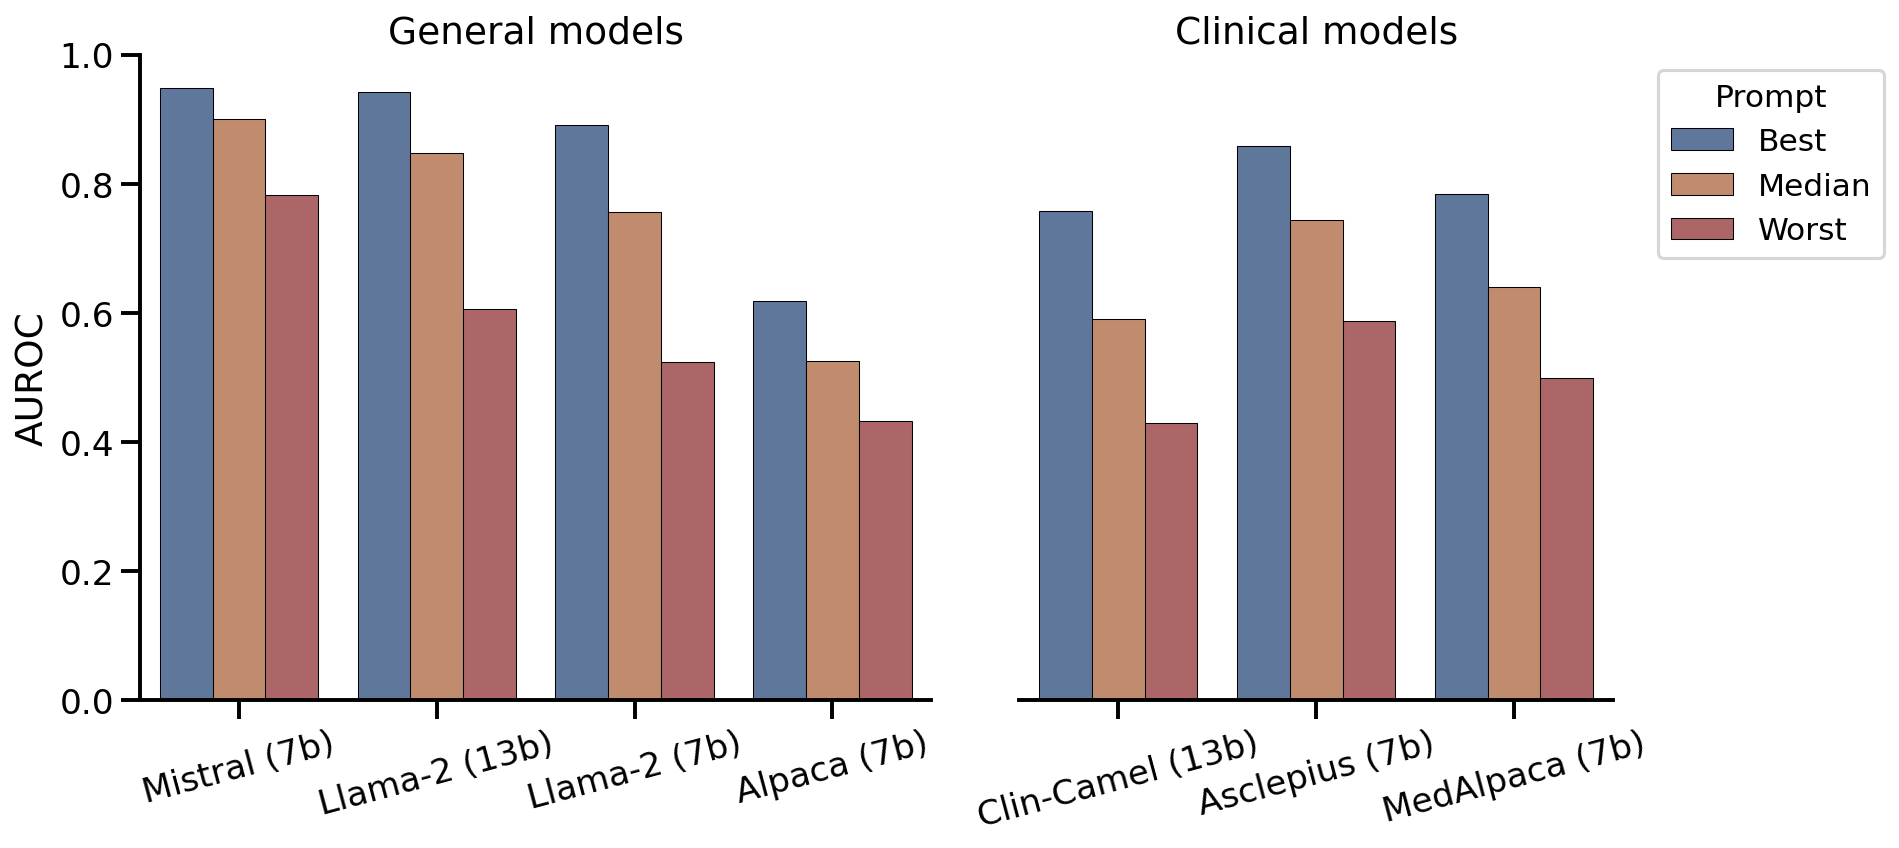

In [10]:
# fig = plt.figure(dpi=100)
colors = sns.color_palette("deep", 10, desat=0.8)
COLOR_MAP = {
    "Best": colors[0],
    "Median": colors[1],
    "Worst": colors[3],
}
sns.set_context("talk")
fig, ax = plt.subplots(
    1,
    2,
    dpi=150,
    figsize=(13, 6),
    gridspec_kw={"width_ratios": [4, 3]},
    sharey=True,
)
# add borders to bars

# set lower title for full figure
# fig.suptitle("Model", y=0.05)

ax1 = ax[0]
results_a = results[results["Model"].isin(models_a)]
g = sns.barplot(
    ax=ax1,
    data=results_a,
    x="Model",
    y="AUROC",
    hue="Prompt",
    # kind="bar",
    palette=COLOR_MAP,
    # height=5,
    # aspect=2,
    edgecolor="black",
    linewidth=0.5,
)

ax1.set_title("General models")
ax1.set_ylim(0, 1)
# remove legend for ax1
ax1.get_legend().remove()
# rotate y axis
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15)


results_b = results[results["Model"].isin(models_b)]
ax2 = ax[1]
# make all bars the same width
g = sns.barplot(
    ax=ax2,
    data=results_b,
    x="Model",
    y="AUROC",
    hue="Prompt",
    # kind="bar",
    palette=COLOR_MAP,
    # height=5,
    # aspect=2,
    edgecolor="black",
    linewidth=0.5,
)

ax1.set_ylim(0, 1)
ax2.set_ylim(0, 1)
ax2.set_title("Clinical models")

# remove x label
ax2.set_xlabel("")
ax1.set_xlabel("")
# rotate y axis
plt.xticks(rotation=15)
# despine
sns.despine()
# remove y spine in ax2 and ticks
ax2.spines["left"].set_visible(False)
ax2.yaxis.set_visible(False)
# put legend outside of the figure
plt.legend(
    title="Prompt",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    fontsize="small",
    title_fontsize="small",
)
plt.tight_layout()

plt.savefig("rankings_cls.pdf", bbox_inches="tight")

# EXTRACTION

In [11]:
df_results_grouped_extraction = pd.read_csv(
    "./processed_csvs/extraction.csv"
).drop(columns=["Unnamed: 0"])
df_results_grouped_extraction = df_results_grouped_extraction.rename(
    columns={"f1_score": "F1"}
)
df_results_grouped = pd.concat(
    [df_results_grouped, df_results_grouped_extraction], axis=0
)

df_results_grouped_extraction["model"].unique()

array(['Llama-2-7b-chat-hf', 'Llama-2-13b-chat', 'alpaca-7b', 'asclepius',
       'clinical-camel-7b', 'medalpaca-7b', 'mistral-7b'], dtype=object)

In [12]:
def get_results_stacked(df_results_grouped, how="max"):
    datasets = df_results_grouped["dataset"].unique()
    models = df_results_grouped["model"].unique()
    if how == "max":
        df_results_grouped_max = (
            df_results_grouped[["dataset", "model", "F1"]]
            .groupby(["dataset", "model"])
            .max()
            .reset_index()
        )
    elif how == "min":
        df_results_grouped_max = (
            df_results_grouped[["dataset", "model", "F1"]]
            .groupby(["dataset", "model"])
            .min()
            .reset_index()
        )
    else:
        df_results_grouped_max = (
            df_results_grouped[["dataset", "model", "F1"]]
            .groupby(["dataset", "model"])
            .mean()
            .reset_index()
        )

    df_results_grouped_max = (
        df_results_grouped_max[["model", "F1"]].groupby("model").mean()
    )

    return df_results_grouped_max

In [13]:
columns = ["dataset", "model", "annotator", "F1"]

df_results_grouped_extraction = pd.read_csv(
    "/work/frink/private_datasets/extraction.csv"
).drop(columns=["Unnamed: 0"])

df_results_grouped_extraction = df_results_grouped_extraction.rename(
    columns={"f1_score": "F1"}
).reset_index()

df_results_grouped_max_cnt = get_results_stacked(df_results_grouped_extraction, "max")
df_results_grouped_min_cnt = get_results_stacked(df_results_grouped_extraction, "min")
df_results_grouped_mean_cnt = get_results_stacked(df_results_grouped_extraction, "mean")
df_results_grouped_max_cnt["type"] = "Best"
df_results_grouped_min_cnt["type"] = "Worst"
df_results_grouped_mean_cnt["type"] = "Median"
results = [
    df_results_grouped_max_cnt,
    df_results_grouped_mean_cnt,
    df_results_grouped_min_cnt,
]
results = pd.concat(results)
results

,F1,type
model,,
Llama-2-13b-chat,0.387880,Best
Llama-2-7b-chat-hf,0.431393,Best
alpaca-7b,0.230052,Best
asclepius,0.347388,Best
clinical-camel-7b,0.414732,Best
medalpaca-7b,0.344597,Best
mistral-7b,0.360897,Best
Llama-2-13b-chat,0.296618,Median
Llama-2-7b-chat-hf,0.352255,Median


In [14]:
results["order"] = results.index.map(ORDER_MAP)
results = results.sort_values(by=["order", "type"])
MODEL_MAP = {
    "Llama-2-7b-chat-hf": "Llama-2 (7b)",
    "asclepius": "Asclepius (7b)",
    "Llama-2-13b-chat": "Llama-2 (13b)",
    "clinical-camel-7b": "Clin-Camel (13b)",
    "alpaca-7b": "Alpaca (7b)",
    "medalpaca-7b": "MedAlpaca (7b)",
    "mistral-7b": "Mistral (7b)",
}
models_a = ["Mistral (7b)", "Llama-2 (7b)", "Llama-2 (13b)", "Alpaca (7b)"]
models_b = ["Asclepius (7b)", "Clin-Camel (13b)", "MedAlpaca (7b)"]
results = results.reset_index()

results["model"] = results.model.map(MODEL_MAP)
results.columns = ["Model", "F1", "Prompt", "order"]

/tmp/ipykernel_37407/1244515320.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15)


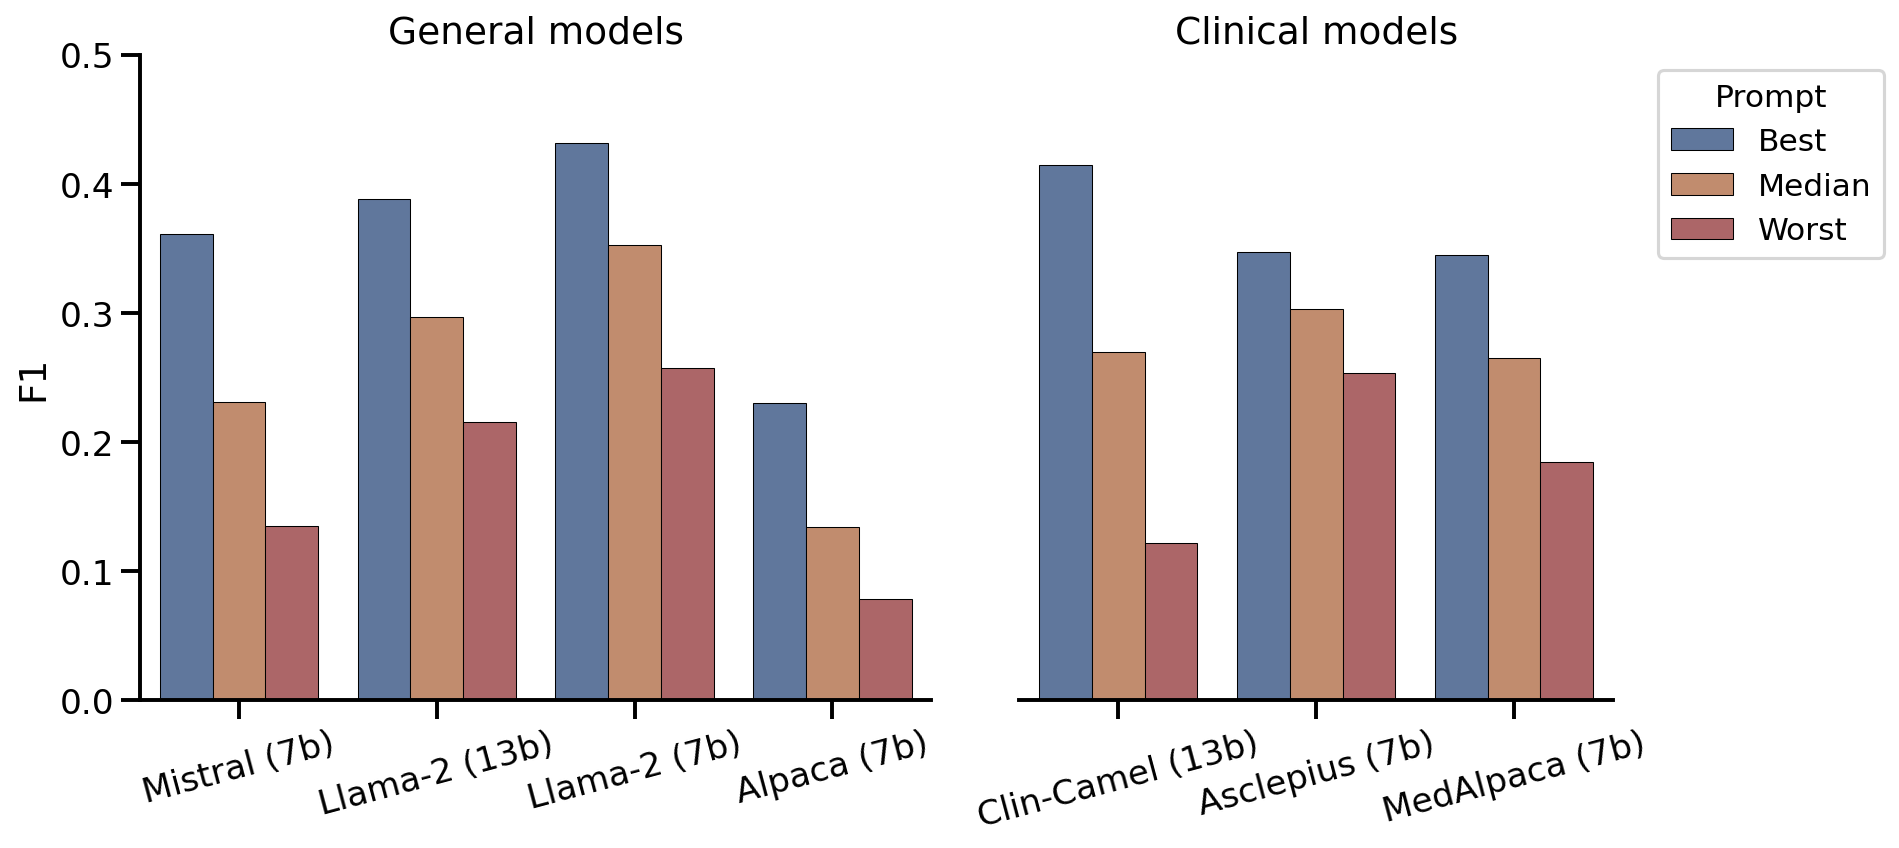

In [15]:
# fig = plt.figure(dpi=100)
sns.set_context("talk")
fig, ax = plt.subplots(
    1,
    2,
    dpi=150,
    figsize=(13, 6),
    gridspec_kw={"width_ratios": [4, 3]},
    sharey=True,
)
# add borders to bars

# set lower title for full figure
# fig.suptitle("Model", y=0.05)

ax1 = ax[0]
results_a = results[results["Model"].isin(models_a)]
g = sns.barplot(
    ax=ax1,
    data=results_a,
    x="Model",
    y="F1",
    hue="Prompt",
    # kind="bar",
    palette=COLOR_MAP,
    # height=5,
    # aspect=2,
    edgecolor="black",
    linewidth=0.5,
)

ax1.set_title("General models")
ax1.set_ylim(0, 1)
# remove legend for ax1
ax1.get_legend().remove()
# rotate y axis
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15)


results_b = results[results["Model"].isin(models_b)]
ax2 = ax[1]
# make all bars the same width
g = sns.barplot(
    ax=ax2,
    data=results_b,
    x="Model",
    y="F1",
    hue="Prompt",
    # kind="bar",
    palette=COLOR_MAP,
    # height=5,
    # aspect=2,
    edgecolor="black",
    linewidth=0.5,
)

ax1.set_ylim(0, 0.5)
ax2.set_ylim(0, 0.5)
ax2.set_title("Clinical models")

# remove x label
ax2.set_xlabel("")
ax1.set_xlabel("")
# rotate y axis
plt.xticks(rotation=15)
# despine
sns.despine()
# remove y spine in ax2 and ticks
ax2.spines["left"].set_visible(False)
ax2.yaxis.set_visible(False)
# put legend outside of the figure
plt.legend(
    title="Prompt",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    fontsize="small",
    title_fontsize="small",
)
plt.tight_layout()

plt.savefig("ranking_ext.pdf", bbox_inches="tight")

KeyError: 'model'

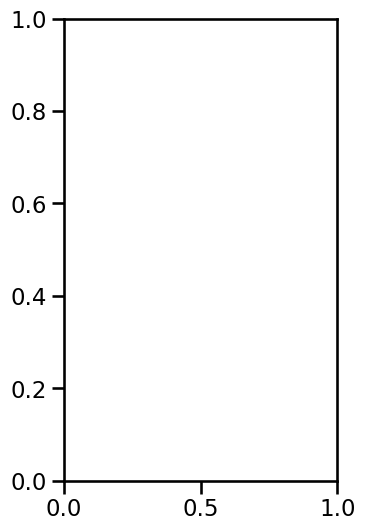

In [45]:
# plot stacked barplots with x being the model and the sub-bars being the rankings -sorted-

my_cmap = plt.colormaps["crest"]
palette = sns.color_palette("crest", as_cmap=True)

fig = plt.figure(figsize=(12, 6))

# do it for the three results
i = 0
for key, df_results_grouped_max_cnt in results.items():

    ax = fig.add_subplot(1, 3, i + 1)
    models = df_results_grouped_max_cnt["model"].unique()
    rankings = [1, 2, 3, 4, 5]
    bottom = np.zeros(len(models))
    for j, model in enumerate(models):
        counts = df_results_grouped_max_cnt[
            df_results_grouped_max_cnt["model"] == model
        ]["count"].values
        if j == 4:
            j = j + 1
        ax.bar(
            rankings,
            counts,
            bottom=bottom,
            label=f"{model}",
            color=my_cmap(j / 6),
        )
        bottom += counts
    i += 1
    ax.set_title(f"{key} prompt")
    # ax.set_title(f"Rankings of models by {key} F1 score")
    if i == 1:
        ax.set_ylabel("Frequency of models at each ranking")
    else:
        # remove y ticks
        ax.set_yticks([])

    ax.set_xlabel("Ranking")
    if i == 3:
        ax.legend()
    plt.xticks(rotation=33)
    ax.set_facecolor("white")
plt.suptitle("Frequency of models at each ranking (extraction)")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=12)
plt.tight_layout()
# plt.ylabel("Frequency of ranking")
plt.xlabel("Ranking")

plt.show()

# save as pdf

fig.savefig("model_rankings_Ext.pdf", bbox_inches="tight")

In [ ]:
# for each model, plot frequency of ranking

for model in models:
    df_results_grouped_max_model = df_results_grouped_max[
        df_results_grouped_max["model"] == model
    ]
    plt.figure(figsize=(10, 5))
    # 
    plt.title(f"Ranking of Annotators for {model}")
    plt.xlabel("Ranking")
    plt.ylabel("Frequency")
    plt.show()
    break

In [ ]:
results_mimic = df_results_grouped[
    df_results_grouped["dataset"] == "mimic_mortality_prediction"
]

In [25]:
results_mimic["F1"].head(50)

576    0.200951
577    0.200951
578    0.200951
579    0.200951
580    0.200951
581    0.200951
582    0.200951
583    0.200951
584    0.200951
585    0.200951
586    0.200951
587    0.200951
588    0.200951
589    0.200951
590    0.200951
591    0.200951
592    0.200951
593    0.200951
594    0.200951
595    0.200951
596    0.200951
597    0.200951
598    0.200951
599    0.200951
600    0.619935
601    0.682746
602    0.562545
603    0.448586
604    0.468223
605    0.699208
606    0.200951
607    0.500435
608    0.833444
609    0.438142
610    0.699047
611    0.760067
612    0.439346
613    0.204502
614    0.658969
615    0.200951
616    0.230771
617    0.477185
618    0.538959
619    0.566928
620    0.455039
621    0.542291
622    0.455039
623    0.455790
624    0.200951
625    0.200951
Name: F1, dtype: float64

In [17]:
# df_results = df_results[
#    ["task_type", "dataset", "model", "gold_class", "instance", "annotator", "correct"]
# ]

df_results_grouped = df_results_grouped.rename(
    columns={
        "correct": "Accuracy",
        "recall": "Recall",
        "precision": "Precision",
        "f1": "F1",
    }
)

# drop any rows containing -1

df_results_grouped = df_results_grouped[
    (df_results_grouped["Precision"] != -1)
    & (df_results_grouped["Recall"] != -1)
    & (df_results_grouped["F1"] != -1)
]

df_results_grouped = (
    df_results_grouped.groupby(["task_type", "dataset", "model", "annotator"])
    .mean()
    .reset_index()
)

In [18]:
DATASET_MAP = {
    "asthma_classification": "Obesity Co-Morbidity (Asthma)",
    "cohort_alcohol_abuse_classification": "Cohort Alcohol Abuse",
    "cad_classification": "Obesity Co-Morbidity (CAD)",
    "cohort_drug_abuse_classification": "Cohort Drug Abuse",
    "cohort_english_classification": "Cohort English",
    "cohort_make_decisions_classification": "Cohort Make Decisions",
    "cohort_abdominal_classification": "Cohort Abdominal",
    "diabetes_mellitus_classification": "Obesity Co-Morbidity (Diabetes Mellitus)",
    "obesity_classification": "Obesity",
}

In [20]:
fig = plt.figure(figsize=(22, 28), dpi=300)

for i, dataset in enumerate(DATASET_MAP.keys()):
    ax = fig.add_subplot(5, 2, i + 1)
    sample_plots_df = df_results_grouped[
        (df_results_grouped["dataset"] == dataset)
    ].copy()
    sample_plots_df = sample_plots_df.drop(
        ["task_type", "gold_class", "instance"], axis=1
    )
    sns.set_theme(style="white")
    name = DATASET_MAP[dataset]
    palette = sns.color_palette("crest")
    sns.violinplot(
        data=sample_plots_df,
        x="F1",
        y="model",
        hue="model",
        palette=palette,
        cut=0,
        ax=ax,
    ).set(title=name)
    sns.set(font_scale=1.2)
    plt.xlim(0, 1.05)
plt.tight_layout()

In [ ]:
def get_results_stacked(df_results_grouped, how="max"):
    datasets = df_results_grouped["dataset"].unique()
    models = df_results_grouped["model"].unique()
    if how == "max":
        df_results_grouped_max = (
            df_results_grouped[["dataset", "model", "auroc"]]
            .groupby(["dataset", "model"])
            .max()
            .reset_index()
        )
    elif how == "min":
        df_results_grouped_max = (
            df_results_grouped[["dataset", "model", "auroc"]]
            .groupby(["dataset", "model"])
            .min()
            .reset_index()
        )
    else:
        df_results_grouped_max = (
            df_results_grouped[["dataset", "model", "auroc"]]
            .groupby(["dataset", "model"])
            .mean()
            .reset_index()
        )
    rankings = []
    for dataset in datasets:
        f1 = df_results_grouped_max[(df_results_grouped_max["dataset"] == dataset)][
            "auroc"
        ].values
        # get ascending argsort for f1
        rankings_dat = len(models) - (
            np.argsort(
                np.argsort(
                    f1,
                )
            )
        )
        rankings.extend(list(rankings_dat))
    df_results_grouped_max["ranking"] = rankings
    df_results_grouped_max = df_results_grouped_max[["model", "ranking"]]
    df_results_grouped_max["count"] = 1
    df_results_grouped_max_cnt = (
        df_results_grouped_max.groupby(["model", "ranking"]).count().reset_index()
    )

    rankings = list([i + 1 for i in range(len(models))])

    # for each possible pair of models, ranking, check if it's in df_results_grouped_max_cnt and if not add it with count = 0
    print(models, rankings)
    for model in models:
        for ranking in rankings:
            if (
                len(
                    df_results_grouped_max_cnt[
                        (df_results_grouped_max_cnt["model"] == model)
                        & (df_results_grouped_max_cnt["ranking"] == ranking)
                    ]
                )
                == 0
            ):
                df_results_grouped_max_cnt.loc[
                    len(df_results_grouped_max_cnt.index)
                ] = {
                    "model": model,
                    "ranking": ranking,
                    "count": 0,
                }

    df_results_grouped_max_cnt = df_results_grouped_max_cnt.sort_values(
        by=["model", "ranking"]
    )
    return df_results_grouped_max_cnt